# Лабораторная работа №5
## Цель работы: Изучить линейные модели, SVM и деревья решений<cite data-cite="ue:lab5"></cite>.

# Задание
Требуется выполнить следующие действия<cite data-cite="ue:lab5"></cite>:

1. Выбрать набор данных (датасет) для&nbsp;решения задачи классификации или регресии.
2. В&nbsp;случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
3. С&nbsp;использованием метода `train_test_split` разделите выборку на&nbsp;обучающую и тестовую.
4. Обучите одну из&nbsp;линейных моделей, SVM и дерево решений. Оцените качество модели с&nbsp;помощью трех подходящих для&nbsp;задачи метрик. Сравните качество полученных моделей.
5. Произведите для&nbsp;каждой модели подбор одного гиперпараметра с&nbsp;использованием `GridSearchCV` и кросс-валидации.
6. Повторите пункт&nbsp;4 для&nbsp;найденных оптимальных значения гиперпараметров. Сравните качество полученных моделей с&nbsp;качеством моделей, полученных в&nbsp;пункте&nbsp;4.

Подключаем библиотеки: 

In [0]:
from google.colab import files
from datetime import datetime
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz, plot_tree

# Enable inline plots
%matplotlib inline

# Set plots formats to save high resolution PNG
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

In [0]:
#Загрузим датасет
uploaded = files.upload()

Saving datasets_418778_1048669_cbb20.csv to datasets_418778_1048669_cbb20.csv


## Предварительная подготовка данных

In [0]:
data = pd.read_csv("Measurement_summary.csv")

Проверим типы данных в датасете:

In [47]:
data.dtypes

Measurement date     object
Station code          int64
Address              object
Latitude            float64
Longitude           float64
SO2                 float64
NO2                 float64
O3                  float64
CO                  float64
PM10                float64
PM2.5               float64
dtype: object

Содержимое датасета:

In [48]:
data.head()

,Measurement date,Station code,Address,Latitude,Longitude,SO2,NO2,O3,CO,PM10,PM2.5
0,2017-01-01 00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005007,0.004,0.059,0.002,1.2,73.0,57.0
1,2017-01-01 01:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005007,0.004,0.058,0.002,1.2,71.0,59.0
2,2017-01-01 02:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005007,0.004,0.056,0.002,1.2,70.0,59.0
3,2017-01-01 03:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005007,0.004,0.056,0.002,1.2,70.0,58.0
4,2017-01-01 04:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005007,0.003,0.051,0.002,1.2,69.0,61.0


Удалим текстовый столбец Address, преобразуем дату в числовой формат

In [49]:
data["Measurement date"] = pd.to_datetime(data["Measurement date"]).astype(np.int64)/1000000

data = data.drop(["Address"], axis=1)
data

,Measurement date,Station code,Latitude,Longitude,SO2,NO2,O3,CO,PM10,PM2.5
0,1.483229e+12,101,37.572016,127.005007,0.004,0.059,0.002,1.2,73.0,57.0
1,1.483232e+12,101,37.572016,127.005007,0.004,0.058,0.002,1.2,71.0,59.0
2,1.483236e+12,101,37.572016,127.005007,0.004,0.056,0.002,1.2,70.0,59.0
3,1.483240e+12,101,37.572016,127.005007,0.004,0.056,0.002,1.2,70.0,58.0
4,1.483243e+12,101,37.572016,127.005007,0.003,0.051,0.002,1.2,69.0,61.0
...,...,...,...,...,...,...,...,...,...,...
513,1.485076e+12,101,37.572016,127.005007,0.004,0.010,0.029,0.3,88.0,14.0
514,1.485079e+12,101,37.572016,127.005007,0.004,0.009,0.030,0.3,62.0,16.0
515,1.485083e+12,101,37.572016,127.005007,0.005,0.010,0.031,0.3,63.0,16.0
516,1.485086e+12,101,37.572016,127.005007,0.005,0.009,0.032,0.3,63.0,20.0


In [50]:
data.dtypes

Measurement date    float64
Station code          int64
Latitude            float64
Longitude           float64
SO2                 float64
NO2                 float64
O3                  float64
CO                  float64
PM10                float64
PM2.5               float64
dtype: object

Размер датасета

In [51]:
data.shape

(518, 10)

Проверим основные статистические характеристики набора данных:

In [52]:
data.describe()

,Measurement date,Station code,Latitude,Longitude,SO2,NO2,O3,CO,PM10,PM2.5
count,5.180000e+02,518.0,5.180000e+02,5.180000e+02,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000
mean,1.484159e+12,101.0,3.757202e+01,1.270050e+02,0.004384,0.038784,0.014178,0.711390,52.490347,36.959459
std,5.388408e+08,0.0,6.401066e-14,1.749625e-12,0.002610,0.019625,0.010952,0.419871,30.897017,27.649651
min,1.483229e+12,101.0,3.757202e+01,1.270050e+02,0.002000,0.007000,0.002000,0.100000,4.000000,1.000000
25%,1.483694e+12,101.0,3.757202e+01,1.270050e+02,0.003000,0.021000,0.003000,0.400000,30.000000,14.000000
50%,1.484159e+12,101.0,3.757202e+01,1.270050e+02,0.004000,0.039000,0.012500,0.600000,45.000000,31.000000
75%,1.484625e+12,101.0,3.757202e+01,1.270050e+02,0.005000,0.054000,0.024000,0.900000,68.750000,53.000000
max,1.485090e+12,101.0,3.757202e+01,1.270050e+02,0.051000,0.086000,0.052000,6.000000,160.000000,149.000000


Проверим наличие пропусков в&nbsp;данных:

In [53]:
data.isnull().sum()

Measurement date    0
Station code        0
Latitude            0
Longitude           0
SO2                 0
NO2                 0
O3                  0
CO                  0
PM10                0
PM2.5               0
dtype: int64

## Разделение данных
Разделим данные на&nbsp;целевой столбец и признаки:

In [0]:
y = data["PM2.5"]
X = data.drop("PM2.5", axis=1)

In [55]:
print(X.head(), "\n")
print(y.head())

   Measurement date  Station code   Latitude  ...     O3   CO  PM10
0      1.483229e+12           101  37.572016  ...  0.002  1.2  73.0
1      1.483232e+12           101  37.572016  ...  0.002  1.2  71.0
2      1.483236e+12           101  37.572016  ...  0.002  1.2  70.0
3      1.483240e+12           101  37.572016  ...  0.002  1.2  70.0
4      1.483243e+12           101  37.572016  ...  0.002  1.2  69.0

[5 rows x 9 columns] 

0    57.0
1    59.0
2    59.0
3    58.0
4    61.0
Name: PM2.5, dtype: float64


In [56]:
print(X.shape)
print(y.shape)

(518, 9)
(518,)


Предобработка данных

In [57]:
columns = X.columns
scaler = StandardScaler()
X = scaler.fit_transform(X)
pd.DataFrame(X, columns=columns).describe()

,Measurement date,Station code,Latitude,Longitude,SO2,NO2,O3,CO,PM10
count,5.180000e+02,518.0,518.0,518.0,5.180000e+02,5.180000e+02,5.180000e+02,5.180000e+02,5.180000e+02
mean,2.614811e-17,0.0,0.0,1.0,-3.804336e-16,-3.827912e-16,-7.287178e-18,1.731776e-16,2.032908e-16
std,1.000967e+00,0.0,0.0,0.0,1.000967e+00,1.000967e+00,1.000967e+00,1.000967e+00,1.000967e+00
min,-1.728710e+00,0.0,0.0,1.0,-9.145276e-01,-1.621080e+00,-1.112951e+00,-1.457545e+00,-1.570936e+00
25%,-8.643552e-01,0.0,0.0,1.0,-5.309444e-01,-9.070331e-01,-1.021558e+00,-7.423493e-01,-7.286169e-01
50%,0.000000e+00,0.0,0.0,1.0,-1.473611e-01,1.102776e-02,-1.533219e-01,-2.655521e-01,-2.426638e-01
75%,8.643552e-01,0.0,0.0,1.0,2.362221e-01,7.760784e-01,8.977006e-01,4.496437e-01,5.267619e-01
max,1.728710e+00,0.0,0.0,1.0,1.788105e+01,2.408187e+00,3.456712e+00,1.260797e+01,3.482976e+00


Разделим выборку на&nbsp;тренировочную и тестовую:

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                            test_size=0.25, random_state=1921264)

In [59]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(388, 9)
(130, 9)
(388,)
(130,)


## Обучение моделей

Напишем функцию, которая считает метрики построенной модели:

In [0]:
def test_model(model):
    print("mean_absolute_error:",
          mean_absolute_error(y_test, model.predict(X_test)))
    print("median_absolute_error:",
          median_absolute_error(y_test, model.predict(X_test)))
    print("r2_score:",
          r2_score(y_test, model.predict(X_test)))

### Линейная модель — Lasso

Запустим метод Lasso с&nbsp;гиперпараметром $\alpha=1$:

In [61]:
las_1 = Lasso(alpha=1.0)
las_1.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

Проверим метрики построенной модели:

In [62]:
test_model(las_1)

mean_absolute_error: 4.979494764499803
median_absolute_error: 4.000764477258743
r2_score: 0.9303470682835011


### SVM

Запустим метод NuSVR с&nbsp;гиперпараметром $\nu=0{,}5$:

In [63]:
nusvr_05 = NuSVR(nu=0.5, gamma='scale')
nusvr_05.fit(X_train, y_train)

NuSVR(C=1.0, cache_size=200, coef0=0.0, degree=3, gamma='scale', kernel='rbf',
      max_iter=-1, nu=0.5, shrinking=True, tol=0.001, verbose=False)

Проверим метрики построенной модели:

In [64]:
test_model(nusvr_05)

mean_absolute_error: 9.01833966598623
median_absolute_error: 5.706304530655714
r2_score: 0.7203051791237243


### Дерево решений

Попробуем дерево решений с&nbsp;неограниченной глубиной дерева:

In [65]:
dt_none = DecisionTreeRegressor(max_depth=None)
dt_none.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

Проверим метрики построенной модели:

In [66]:
test_model(dt_none)

mean_absolute_error: 2.730769230769231
median_absolute_error: 2.0
r2_score: 0.9804172449201954


Дерево решений показало наилучший результат

In [0]:
def stat_tree(estimator):
    n_nodes = estimator.tree_.node_count
    children_left = estimator.tree_.children_left
    children_right = estimator.tree_.children_right

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True

    print("Всего узлов:", n_nodes)
    print("Листовых узлов:", sum(is_leaves))
    print("Глубина дерева:", max(node_depth))
    print("Минимальная глубина листьев дерева:", min(node_depth[is_leaves]))
    print("Средняя глубина листьев дерева:", node_depth[is_leaves].mean())

In [68]:
stat_tree(dt_none)

Всего узлов: 623
Листовых узлов: 312
Глубина дерева: 16
Минимальная глубина листьев дерева: 3
Средняя глубина листьев дерева: 9.945512820512821


## Подбор гиперпараметра $K$

### Линейная модель — Lasso

Введем список настраиваемых параметров:

In [69]:
param_range = np.arange(0.001, 2.01, 0.1)
tuned_parameters = [{'alpha': param_range}]
tuned_parameters

[{'alpha': array([1.000e-03, 1.010e-01, 2.010e-01, 3.010e-01, 4.010e-01, 5.010e-01,
         6.010e-01, 7.010e-01, 8.010e-01, 9.010e-01, 1.001e+00, 1.101e+00,
         1.201e+00, 1.301e+00, 1.401e+00, 1.501e+00, 1.601e+00, 1.701e+00,
         1.801e+00, 1.901e+00, 2.001e+00])}]

Запустим подбор параметра:

In [70]:
gs = GridSearchCV(Lasso(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

Проверим результаты при&nbsp;разных значения гиперпараметра на&nbsp;тренировочном наборе данных:

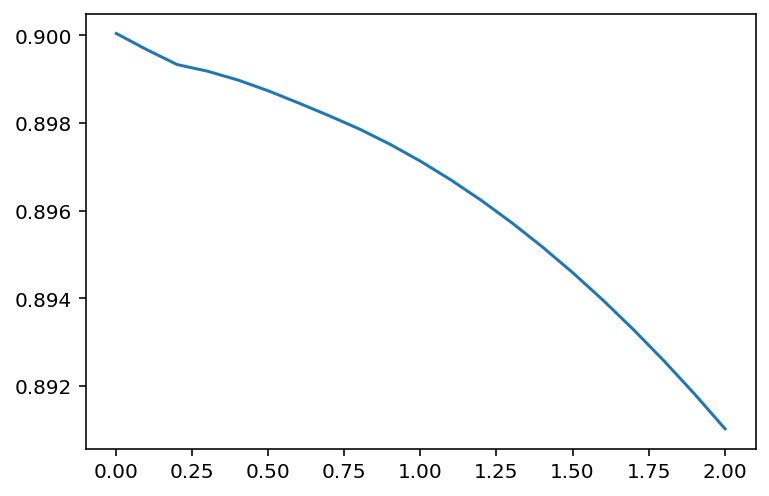

In [71]:
plt.plot(param_range, gs.cv_results_["mean_train_score"]);

Видно, что метод Lasso в данном случае не является лучшим вариантом, т.к. выдает плохие результаты

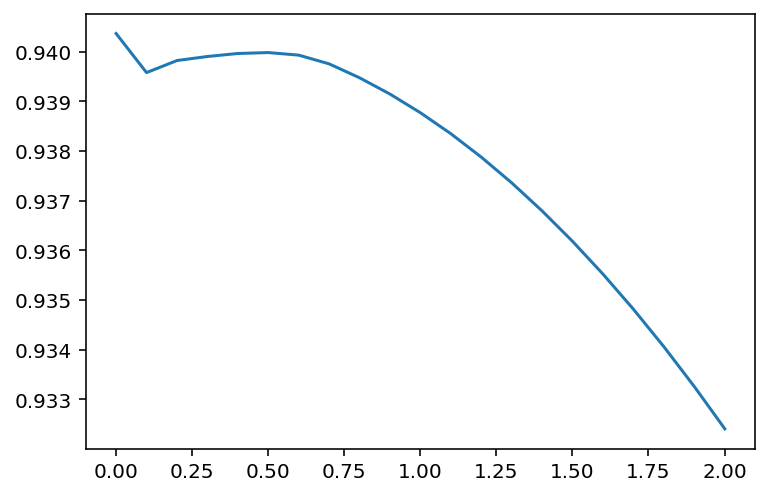

In [72]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

Проверим на примере обычной линейной регрессии:

In [101]:
reg = LinearRegression()
reg.fit(X_train, y_train)
test_model(reg)

mean_absolute_error: 5.109650114918574
median_absolute_error: 4.056833856956942
r2_score: 0.9303028497642629


### SVM

Введем список настраиваемых параметров:

In [102]:
param_range = np.arange(0.1, 1.01, 0.1)
tuned_parameters = [{'nu': param_range}]
tuned_parameters

[{'nu': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])}]

Запустим подбор параметра:

In [79]:
gs = GridSearchCV(NuSVR(gamma='scale'), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

NuSVR(C=1.0, cache_size=200, coef0=0.0, degree=3, gamma='scale', kernel='rbf',
      max_iter=-1, nu=0.8, shrinking=True, tol=0.001, verbose=False)

Проверим результаты при&nbsp;разных значения гиперпараметра на&nbsp;тренировочном наборе данных:

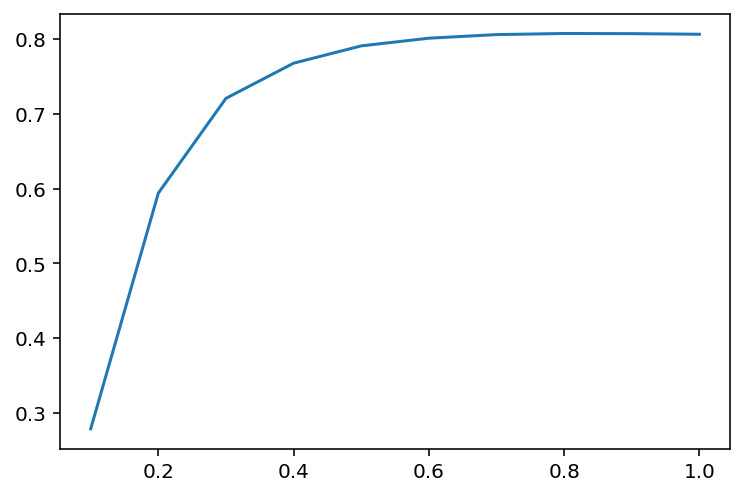

In [80]:
plt.plot(param_range, gs.cv_results_["mean_train_score"]);

Видно, что метод NuSVR справляется лучше, но не глобально.

На&nbsp;тестовом наборе данных картина ровно та же:

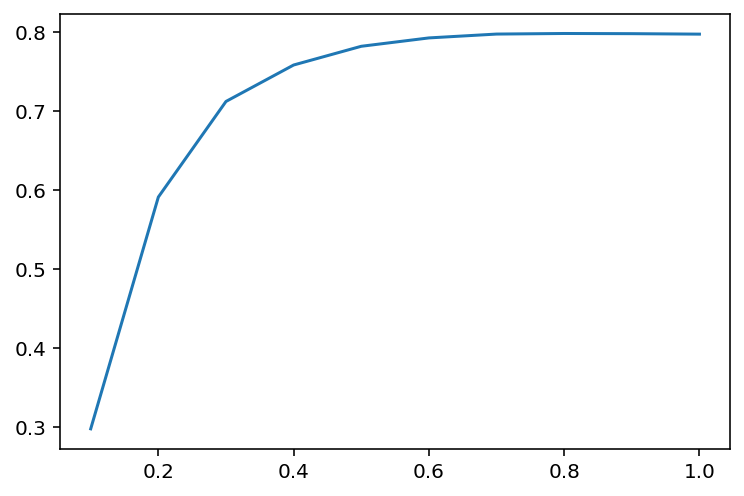

In [81]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

Проведем обучение заново с параметром 0,3

In [82]:
nusvr_05 = NuSVR(nu=0.3, gamma='scale')
nusvr_05.fit(X_train, y_train)

NuSVR(C=1.0, cache_size=200, coef0=0.0, degree=3, gamma='scale', kernel='rbf',
      max_iter=-1, nu=0.3, shrinking=True, tol=0.001, verbose=False)

In [83]:
test_model(nusvr_05)

mean_absolute_error: 11.601506871059064
median_absolute_error: 8.36474118380768
r2_score: 0.6417843721691924


К сожалению, результаты снова ухудшились

### Дерево решений

Введем список настраиваемых параметров:

In [84]:
param_range = np.arange(1, 51, 2)
tuned_parameters = [{'max_depth': param_range}]
tuned_parameters

[{'max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
         35, 37, 39, 41, 43, 45, 47, 49])}]

Запустим подбор параметра:

In [91]:
gs = GridSearchCV(DecisionTreeRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=43,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

Проверим результаты при&nbsp;разных значения гиперпараметра на&nbsp;тренировочном наборе данных:

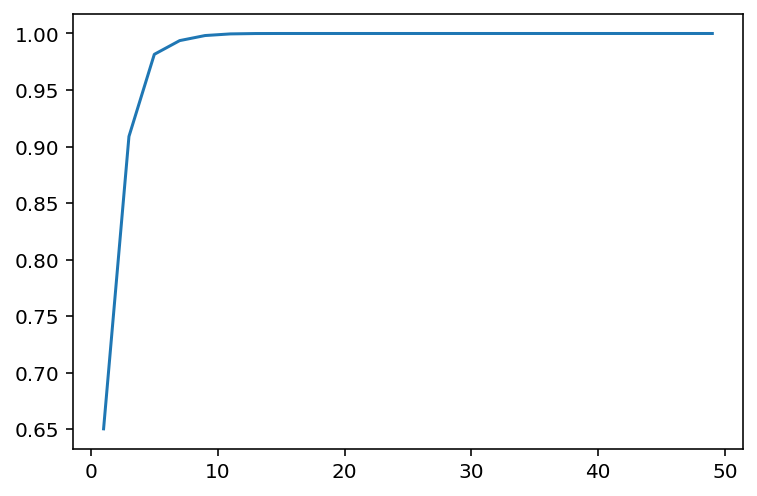

In [92]:
plt.plot(param_range, gs.cv_results_["mean_train_score"]);

Видно, что на&nbsp;тестовой выборке модель легко переобучается.

На&nbsp;тестовом наборе данных картина аналогична:

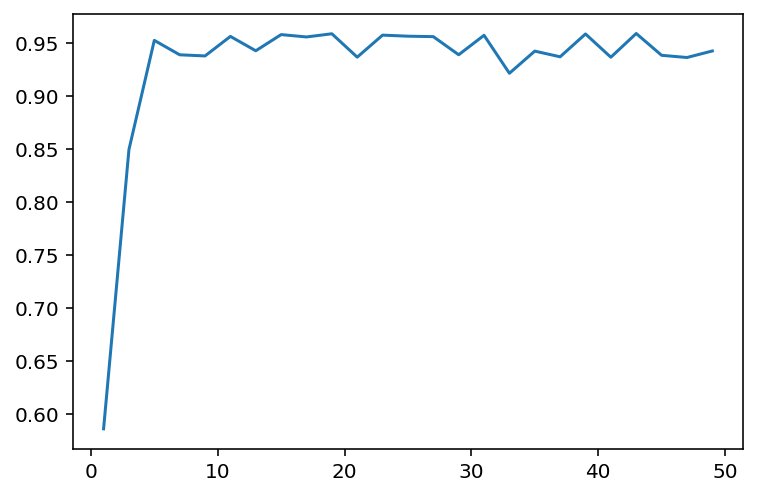

In [93]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

Проведем дополнительное исследование в&nbsp;районе пика.

In [103]:
param_range = np.arange(7, 14, 1)
tuned_parameters = [{'max_depth': param_range}]
tuned_parameters

[{'max_depth': array([ 7,  8,  9, 10, 11, 12, 13])}]

In [109]:
gs = GridSearchCV(DecisionTreeRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=12,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

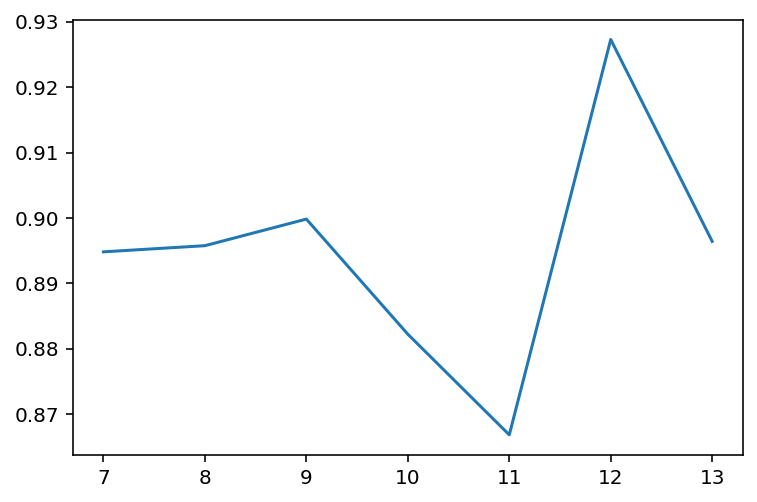

In [110]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

Получили, что глубину дерева необходимо ограничить 12&nbsp;уровнями. Проверим этот результат.

In [111]:
reg = gs.best_estimator_
reg.fit(X_train, y_train)
test_model(reg)

mean_absolute_error: 2.937179487179487
median_absolute_error: 2.0
r2_score: 0.9781035502651158


Вновь посмотрим статистику получившегося дерева решений.

In [112]:
stat_tree(reg)

Всего узлов: 579
Листовых узлов: 290
Глубина дерева: 12
Минимальная глубина листьев дерева: 3
Средняя глубина листьев дерева: 9.575862068965517


В&nbsp;целом получили примерно тот же результат. 
Посмотрим на&nbsp;построенное дерево.

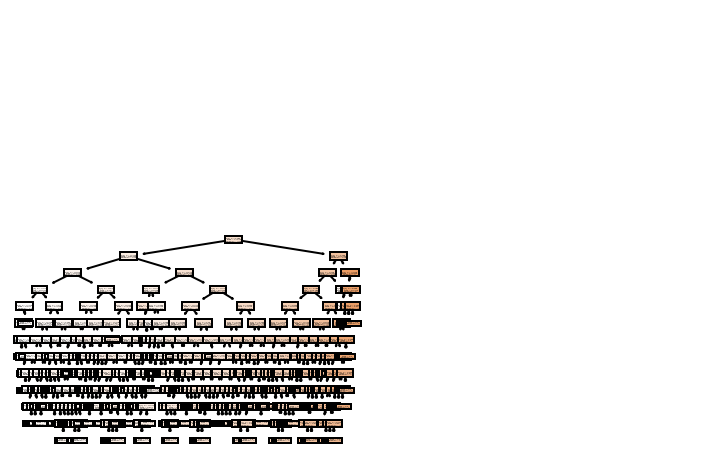

In [113]:
plot_tree(reg, filled=True);

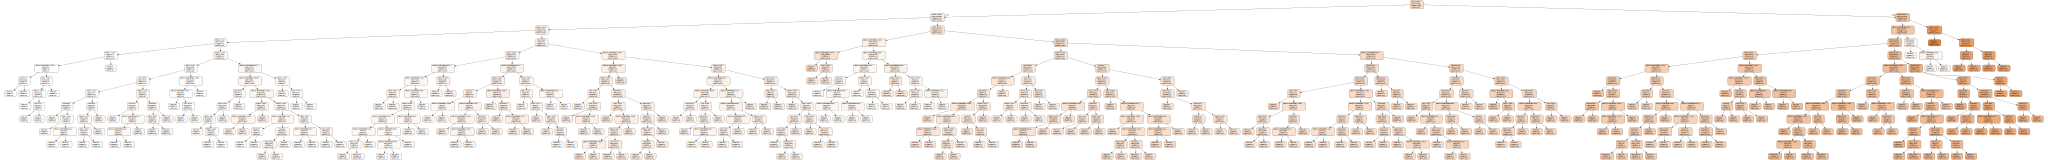

In [114]:
dot_data = export_graphviz(reg, out_file=None, feature_names=columns,
                           filled=True, rounded=True,
                           special_characters=True)
graph = graphviz.Source(dot_data)
graph

Данное дерево уже выглядит более наглядно. Заметно что было сгенерировано множество условий, и, можно сказать, чир модель была переобучена, с другой стороны, для задачи регресии древо и не могло быть построено иначе. Несмотря на то что на тестовой выборке древо показало свою работоспособность, лучше использовать данный метод для задач классификации.